### Learning RNN

    Author: 彭日骏
    Time: 2025/10/13

尝试自主code一个RNN模型，训练一个时间序列预测模型，数据集为Gemini推荐的适合初学者训练RNN模型的`Daily Minimum Temperatures in Melbourne`

---

### RNN

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# 数据读入进一个pandas的dataframe
# parse_dates=True可自动将日期字符串转换为日期对象
df = pd.read_csv('./data/daily-minimum-temperatures-in-me.csv', index_col='Date', parse_dates=True)

---

#### 数据检查与清洗

---

In [3]:
df.columns = df.columns.str.strip() # 清理列名头尾的空格
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [18]:
# 数据清洗
# 只取出温度这一列，且将pandas的dataframe提取出单列换为numpy的float数组
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce') # ---???

# 注意记得删除NaN的数据行
df.dropna(inplace=True)
data = df['Temp'].astype(float)

In [19]:
df['Temp'].head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

In [20]:
df['Temp'].isnull().sum()

np.int64(0)

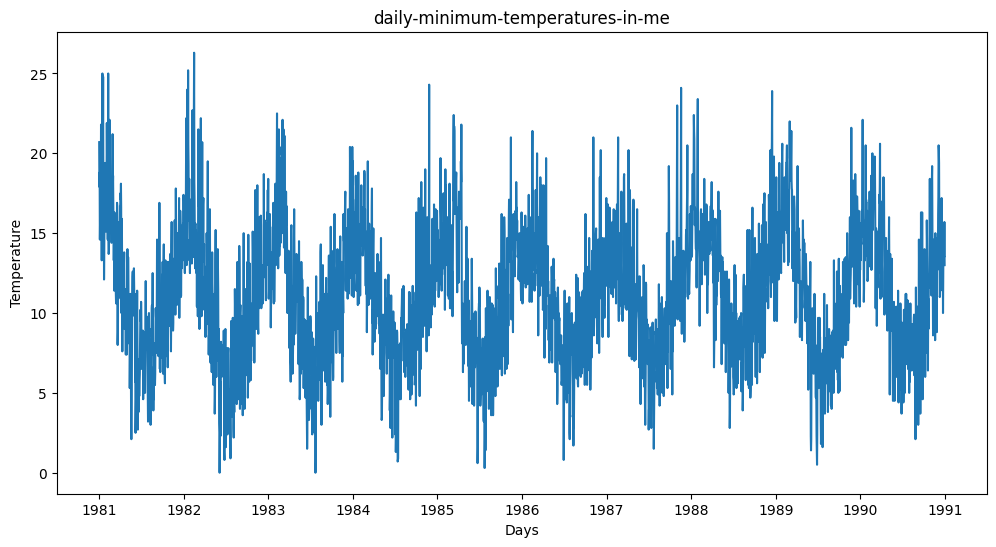

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title('daily-minimum-temperatures-in-me')
plt.ylabel('Temperature')
plt.xlabel('Days')
plt.show()

---

#### 笔记

`MinMaxScaler`预处理数据，可将数据归一化到一个`feature_range(Min, Max)`的范围内

对用`tanh`做激活函数的RNN而言，处理的数据位于`[-1, 1]`范围内，模型效果最好

`scaler.fit_transform()`会自动计算数据(最小值, 最大值)以此为(-1, 1)

`data.reshape(-1, 1)`的作用是？将一维的 data 数组转换为二维列向量，以满足 MinMaxScaler 的输入要求（即每行为一个样本，每列为一个特征）

---

In [22]:
# 数据归一化
# 神经网络对输入数据尺度很敏感，归一化让模型更容易收敛
# 此处归一化至[-1, 1], 比起归一化到[0, 1]的优点是?
# 如何归一化到[0, 1]?
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.values.reshape(-1, 1))

In [23]:
np.isnan(data_normalized).any()

np.False_

---

#### 笔记

`RNN`不能直接处理 **长序列** ，需要对数据进行划分成n个**输入序列-输出值对**

`每Time_window天数据`做一个**输入序列**，`紧随其后的一天数据`作为**输出值**，即这个输入序列预测出的输出值的标签正确值，用于计算模型损失

`Time_window`时间序列窗口值，重要超参数，决定了模型预测使用多远的历史数据。

太小可能信息不足

太大可能引入噪音

`划分训练集和测试集：`通常**时间序列数据**不能随机打乱，按时间顺序，将0.8划分为**训练集**，剩下0.2作为**测试集**

**注意** ：并非切分，数据间可重合

如：(0->9, 10), (1->10, 11), ..., (Length-tw-1->Length-1, Length)

---

In [24]:
# 数据划分
def create_inout_sequences(input_data, tw):
    '''
    Turn Inputs to Samples
    Parameters:
        input_data: long inputs'time sequences
        tw: time_window, A train sequence length
    Return:
        Samples dataframe contains (train sequences, labeled true output)
    '''
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw): 
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        inout_seq.append((train_seq, train_label))
    
    return inout_seq

time_window = 10
all_sequences = create_inout_sequences(data_normalized, time_window)

In [25]:
train_size = int(len(all_sequences) * 0.8)
train_data = all_sequences[:train_size]
test_data = all_sequences[train_size:]

---

#### 笔记

`DataLoader`: 自动把数据分成小批量放入模型训练，并且可以并行加载数据，部分需要提升效率的场合至关紧要

`batch_size`: 决定一次性喂给模型多少样本，喂的多训练速度慢，喂的少模型可能不收敛或者稳定性很差

`shuffle=True`: 打乱**样本对**的顺序，防止模型过拟合，学习到更加通用的特征---???，因为已经对按照create_inout_sequences()与DataLoader中的Batch_size进行了按顺序的划分，此时的打乱不会影响时间序列内部顺序

`labels = torch.FloatTensor(np.array(labels)).squeeze(1)`: **至关重要** 压缩二维Tensor张量至一维，以便后续与模型预测值y_pred进行MSELoss比较

---

In [26]:
def create_dataloader(data, batch_size, is_shuffle):
    '''
    Turn (train_seq, train_label) to PyTorch DataLoader (Tensor)
    '''
    # 输入序列与正确值标签分开
    sequences = [item[0] for item in data]
    labels = [item[1] for item in data]

    # 转换为PyTorch的Tensor张量
    sequences = torch.FloatTensor(np.array(sequences))
    labels = torch.FloatTensor(np.array(labels)).squeeze(1) # 压缩二维Tensor张量至一维，以便后续与模型预测值y_pred进行MSELoss比较

    # 创建TensorDataset与DataLoader
    dataset = TensorDataset(sequences, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_shuffle)
    return dataloader

batch_size = 64
train_loader = create_dataloader(train_data, batch_size, is_shuffle=False)
test_loader = create_dataloader(test_data, batch_size, is_shuffle=False) # 测试集不需要打乱顺序

---

#### 笔记：

`nn.Module`: PyTorch所有模型的基类

`__init__`: 定义模型的“层”所需要用到的构造函数

`nn.RNN`: PyTorch内置的RNN层，其中`hidden_layer_size`是隐藏层层数，过大易过拟合

`h0`: 每次处理一个新的Batch, 都需要一个初始的隐藏状态。通常全零初始化

**拓展** : 

`增加模型的宽度`: 增大`hidden_layer_size`, 使得模型在每个时间步存储更多的信息

`增加模型的深度`: 多层RNN, 使得模型能学习到更抽象，更高层次的时间特征，可添加`num_layers`参数

```python
    self.rnn = nn.RNN(input_size, hidden_layer_size, **num_layers=2**, batch_first=True)
```

`引入Dropout正则化`: 避免**过拟合(Overfitting)**，可以使用Dropout。在训练过程中，它会以一定的概率随机地将一些神经元的输出设置为0，迫使网络不会过度依赖任何一个神经元，从而学习到更稳定的特征。

*注：当且仅当 `num_layers`>1 时有效，Dropout应用于层与层之间*

```python
    self.rnn = nn.RNN(input_size, hidden_layer_size, **num_layers=2, dropout=0.2**, batch_first=True)

    ...

    last_time_step_out = self.dropout(rnn_out[:, -1, :])
    predictions = self.linear(last_time_step_out)
    return predictions
```

---

In [27]:
# RNN Model
class temp_predict_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        '''
        Def RNN layer
        Parameters:
            input_size: num of features for the input sequence（输入特征的数量），只需要预测温度一个特征
            hidden_layer_size
            batch_first ---???
                        let Tensor turn to (batch_size, seq_length, input_size)
        '''
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True) # ---???
        self.linear = nn.Linear(hidden_layer_size, output_size)
    def forward(self, input_seq):
        '''
        Forward Algorithm
        '''
        # RNN需要初始化隐藏状态h_0 = (num_layers, batch_size, hidden_size)
        # 且我们需要把h0移植至device
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        # RNN需要传入输入序列和初始隐藏状态
        # rnn_out 是所有时间步的输出
        # rnn_out 为常用Tensor张量(batch_size, seq_length, input_size) ---???为何这样处理数据更简便
        # hidden 是最后一个时间步的隐藏状态
        rnn_out, hidden = self.rnn(input_seq, h0)

        # 只关心序列最后一个时间步的输出，因为它包含了整个序列的信息---???
        # rnn[:, -1, :]可丢弃掉中间维度seq_length, 变为二维Tensor张量(batch_size, hidden_size)
        last_time_step_out = rnn_out[:, -1, :]

        # 全连接层
        predictions = self.linear(last_time_step_out)

        return predictions

In [28]:
model = temp_predict_RNN().to(device)

---

In [29]:
# 回归问题，定义均方误差(MSE Loss)
loss_function = nn.MSELoss()
# 常用Adam优化器做梯度下降
# Adam算法结合了动量（Momentum）和RMSprop的优点
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Train Model
epochs = 100
train_losses = [] # 可视化模型Loss，观察收敛效果

model.train()

for i in range(epochs):
    epoch_loss = 0.0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if (i+1) % 10 ==0:
        print(f'Epoch: {i+1:3d}/{epochs}, Loss: {avg_epoch_loss:.6f}')

print("训练完成!")

Epoch:  10/100, Loss: nan
Epoch:  20/100, Loss: nan
Epoch:  30/100, Loss: nan
Epoch:  40/100, Loss: nan
Epoch:  50/100, Loss: nan
Epoch:  60/100, Loss: nan
Epoch:  70/100, Loss: nan
Epoch:  80/100, Loss: nan
Epoch:  90/100, Loss: nan
Epoch: 100/100, Loss: nan
训练完成!


---

#### Debug Log

---

In [17]:
y_pred

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

不难观察到，loss，y_pred全部都是NaN，显然第一次训练失败了

怎么排查呢？首先想到的第一个可能就是，模型的**梯度爆炸**了，因为RNN很可能会梯度爆炸。但是我又发现，在第一次得到的y_pred里，就已经全部都是NaN值了，所以问题应该不是梯度爆炸...到底哪里出了问题呢？

惊讶的发现，原来数据从最开始就有NaN，好了破案了，数据预处理不干净，最简单的办法是把NaN的行删除

在第4个cell中加入以下代码

```python
    df.dropna(inplace=True)
```

再重新训练一次就成功了

In [41]:
# 回归问题，定义均方误差(MSE Loss)
loss_function = nn.MSELoss()
# 常用Adam优化器做梯度下降
# Adam算法结合了动量（Momentum）和RMSprop的优点
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [42]:
# Train Model
epochs = 1000
train_losses = [] # 可视化模型Loss，观察收敛效果

model.train()

for i in range(epochs):
    epoch_loss = 0.0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if (i+1) % 10 ==0:
        print(f'Epoch: {i+1:3d}/{epochs}, Loss: {avg_epoch_loss:.6f}')

print("训练完成!")

Epoch:  10/1000, Loss: 0.032233
Epoch:  20/1000, Loss: 0.032124
Epoch:  30/1000, Loss: 0.032024
Epoch:  40/1000, Loss: 0.031928
Epoch:  50/1000, Loss: 0.031833
Epoch:  60/1000, Loss: 0.031740
Epoch:  70/1000, Loss: 0.031648
Epoch:  80/1000, Loss: 0.031555
Epoch:  90/1000, Loss: 0.031463
Epoch: 100/1000, Loss: 0.031371
Epoch: 110/1000, Loss: 0.031279
Epoch: 120/1000, Loss: 0.031186
Epoch: 130/1000, Loss: 0.031093
Epoch: 140/1000, Loss: 0.030999
Epoch: 150/1000, Loss: 0.030904
Epoch: 160/1000, Loss: 0.030808
Epoch: 170/1000, Loss: 0.030711
Epoch: 180/1000, Loss: 0.030614
Epoch: 190/1000, Loss: 0.030515
Epoch: 200/1000, Loss: 0.030416
Epoch: 210/1000, Loss: 0.030316
Epoch: 220/1000, Loss: 0.030215
Epoch: 230/1000, Loss: 0.030115
Epoch: 240/1000, Loss: 0.030014
Epoch: 250/1000, Loss: 0.029913
Epoch: 260/1000, Loss: 0.029813
Epoch: 270/1000, Loss: 0.029713
Epoch: 280/1000, Loss: 0.029614
Epoch: 290/1000, Loss: 0.029516
Epoch: 300/1000, Loss: 0.029418
Epoch: 310/1000, Loss: 0.029321
Epoch: 3

---

#### 训练过程Loss可视化

我们发现训练的Loss从10/100到100/100中间，都没有太大变化，我们可以观察一下Loss看看是否有收敛的趋向

如果有说明模型没有问题，我们可以调低学习率，进行更精确的学习，或者使用优化算法**学习率调度(Learning Rate Scheduling)**

---

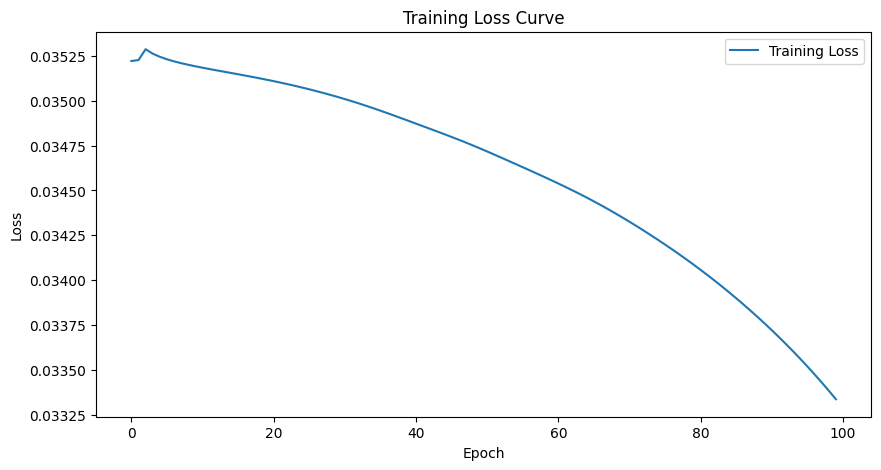

In [40]:
# Loss收敛过程可视化
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

好的这张图看起来似乎显示我们的模型并不怎么收敛...

我不信邪地调低一下学习率再试试

由于学习率调低，我们可以多训练几轮，正好现在我准备睡午觉...

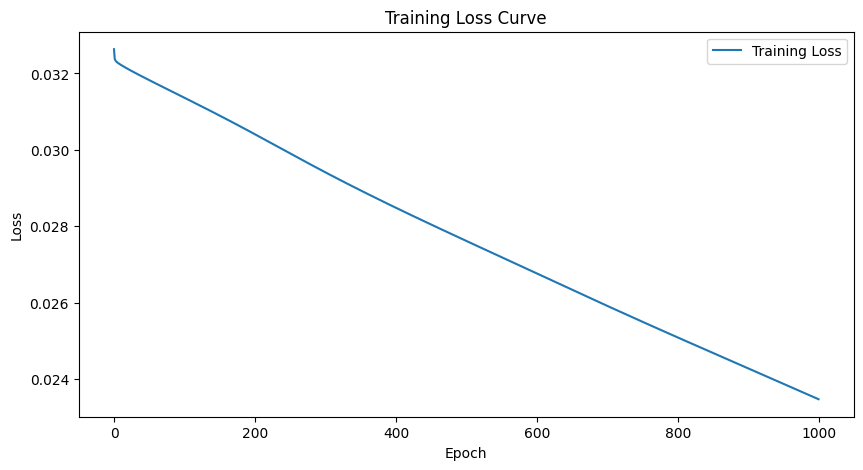

In [43]:
# Loss收敛过程可视化
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

睡醒了

啊这？？不对吧，哥们。这对吗？？对的不对对的不对不对不对。

不管了，先评估一下模型再说

---

#### 模型评估

#### 笔记

`with torch.no_grad():`: 所有计算不再追踪梯度，显著加快计算速度并减少内存占用

---

In [44]:
# 评估模型
model.eval()
test_predictions = []
actual_values = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq = seq.to(device)

        preds = model(seq)

        test_predictions.extend(preds.cpu().numpy().flatten())
        actual_values.extend(labels.numpy().flatten())

# 将预测值反归一化，得到原始的温度
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1))

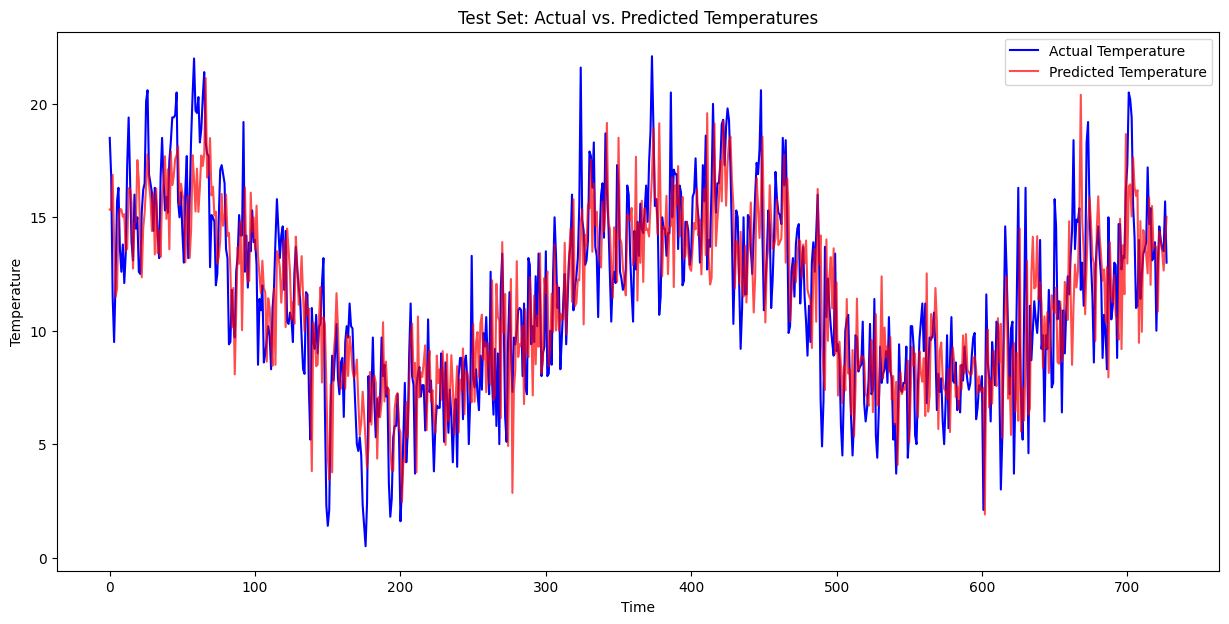

In [45]:
# 可视化评估模型预测效果
plt.figure(figsize=(15, 7))
plt.plot(actual_values_inv, label='Actual Temperature', color='blue')
plt.plot(test_predictions_inv, label='Predicted Temperature', color='red', alpha=0.7) # --???alpha
plt.title('Test Set: Actual vs. Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

怎么学的那么难看。~~废物！~~

但是大体趋势是对的，模型应该还是成功收敛了，训练的一般成功

---

#### 优化算法：学习率调度(Learning Rate Scheduling)

`学习率调度(Learning Rate Scheduling)`: 使学习率在训练初期大一些，使模型快速收敛；训练后期小一些，在模型最优点附近微调，以便得到更好的最优点

```python
    # 调用
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 当某个指标停止改进时，降低学习率。这里我们监控验证集损失（validation loss）
    # factor: 降低的倍数; patience: 多少个epoch没改进就降低;
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)
    for epoch in ...: 
        ...
        single_loss = loss_function(y_pred, labels)
        scheduler.step(single_loss)
```

---

#### 优化算法：梯度裁剪(Gradient Clipping)

`梯度裁剪(Gradient Clipping)`: 防止**梯度爆炸** 算法核心思想：**为梯度大小设定一个上限**，在优化器更新权重之前，检查一下所有参数的梯度范数。如果这个范数超过了我们设定的阈值，我们就按比例把所有梯度都缩小，直到范数等于阈值为止。

虽然并没有梯度爆炸，但这里还是贴出一个优化了梯度的代码

只需要

```python
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
```

---


如是我决定，加入**学习率调度优化**

In [68]:
# 回归问题，定义均方误差(MSE Loss)
loss_function = nn.MSELoss()
# 常用Adam优化器做梯度下降
# Adam算法结合了动量（Momentum）和RMSprop的优点
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduling
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

In [69]:
# Train Model
epochs = 1000
train_losses = [] # 可视化模型Loss，观察收敛效果

model.train()

for i in range(epochs):
    epoch_loss = 0.0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        scheduler.step(single_loss)

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if (i+1) % 10 ==0:
        print(f'Epoch: {i+1:3d}/{epochs}, Loss: {avg_epoch_loss:.6f}')

print("训练完成!")

Epoch:  10/1000, Loss: 0.025871
Epoch:  20/1000, Loss: 0.025867
Epoch:  30/1000, Loss: 0.025863
Epoch:  40/1000, Loss: 0.025859
Epoch:  50/1000, Loss: 0.025855
Epoch:  60/1000, Loss: 0.025850
Epoch:  70/1000, Loss: 0.025846
Epoch:  80/1000, Loss: 0.025842
Epoch:  90/1000, Loss: 0.025838
Epoch: 100/1000, Loss: 0.025834
Epoch: 110/1000, Loss: 0.025830
Epoch: 120/1000, Loss: 0.025826
Epoch: 130/1000, Loss: 0.025822
Epoch: 140/1000, Loss: 0.025818
Epoch: 150/1000, Loss: 0.025814
Epoch: 160/1000, Loss: 0.025810
Epoch: 170/1000, Loss: 0.025806
Epoch: 180/1000, Loss: 0.025802
Epoch: 190/1000, Loss: 0.025798
Epoch: 200/1000, Loss: 0.025794
Epoch: 210/1000, Loss: 0.025790
Epoch: 220/1000, Loss: 0.025786
Epoch: 230/1000, Loss: 0.025782
Epoch: 240/1000, Loss: 0.025778
Epoch: 250/1000, Loss: 0.025774
Epoch: 260/1000, Loss: 0.025770
Epoch: 270/1000, Loss: 0.025767
Epoch: 280/1000, Loss: 0.025763
Epoch: 290/1000, Loss: 0.025759
Epoch: 300/1000, Loss: 0.025755
Epoch: 310/1000, Loss: 0.025751
Epoch: 3

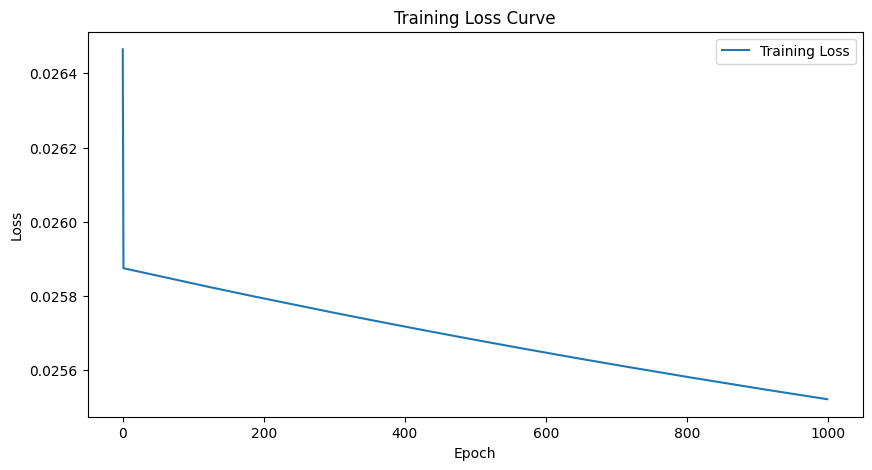

In [70]:
# Loss收敛过程可视化
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
# 再次评估模型
model.eval()
test_predictions = []
actual_values = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq = seq.to(device)

        preds = model(seq)

        test_predictions.extend(preds.cpu().numpy().flatten())
        actual_values.extend(labels.numpy().flatten())

# 将预测值反归一化，得到原始的温度
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1))

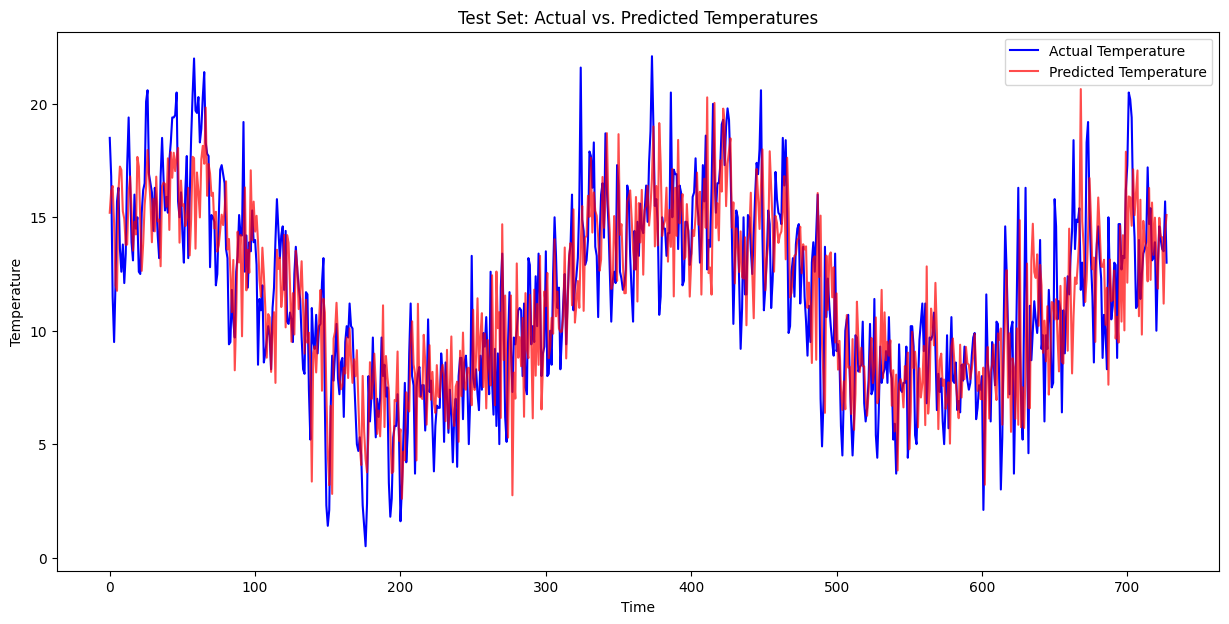

In [72]:
# 可视化评估模型预测效果
plt.figure(figsize=(15, 7))
plt.plot(actual_values_inv, label='Actual Temperature', color='blue')
plt.plot(test_predictions_inv, label='Predicted Temperature', color='red', alpha=0.7) # --???alpha
plt.title('Test Set: Actual vs. Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

好像没啥变化

---

#### 算法：Adam(Adaptive Moment Estimation) (自适应矩估计)
---

    Time: 2025/10/16

我按照老师给的链接，阅读了这个 https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo

里面的RNN模型是完全使用numpy写的，并没有使用PyTorch，遵循了我学的算法的逻辑去训练。

确实比使用PyTorch更适合新手去理解模型。在使用PyTorch训练上述RNN模型的时候，我其实对**Tensor张量**并没有很清晰的概念，使用numpy做字典映射构建矩阵计算才符合我学习的RNN模型的逻辑，使用张量的PyTorch对我而言其实有一些些超纲

对于上周CNN留下的问题，这周进行RNN训练的时候也不得不面对的一个**黑箱**，就是**Adam优化器**

正好在 https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo 链接里面，rnn_utils.py 中就用numpy写出了Adam优化器的实现过程，方便我进行学习。


`Adam`算法结合了`动量(Momentum)`和`RMSprop`的优点

`动量(Momentum)`: 

`普通梯度下降(SGD)`容易在沟壑处左右震荡，一直难收敛到最低点，而`动量(Momentum)`就等于是给**收敛点**一个**动量**，避免其在两壁间反复震荡，而是会受`动量`赋予的影响，更快到达最低点。

$v_{t} = \beta_1 v_{t-1} + (1-\beta_1) g_t$

$\beta_1$ 控制着**惯性**大小，显然 $\beta_1$ 越大，本次速度更易受到上次速度的影响，如果发生震荡，就更容易被拉住！I know it！

`RMSprop(Root Mean Square Propagation)`: 

**本质目的：** 梯度一直很大的参数，学习率小一点；梯度一直很小的参数，学习率大一点。

$s_{t} = \beta_2 s_{t-1} + (1-\beta_2) g_t^2$

$\beta_1$ 控制着 $ s_{t}$ 的过去记录权重，更新参数时除以 $\sqrt{s_t}$ 即可实现**学习率的自适应缩放**。

`Adam`: 

$v_{t}$(称**一阶矩估计**)

$s_{t}$(称**二阶矩估计**)

$\beta_1$ 一阶矩估计的指数衰减率（动量系数）

$\beta_2$ 二阶矩估计的指数衰减率（RMSprop系数）

$\alpha$ 全局学习率

$\epsilon$ 防止分母为零

$\theta_t = \theta_{t-1} - \alpha \frac{\hat{v_t}}{\sqrt{\hat{s_t}} + \epsilon}$其中，$\hat{v_t}$ 和 $\hat{s_t}$ 是**经过偏差修正**后的一阶和二阶矩

**偏差修正** : 初始化为0会带来偏差，可通过

$\hat{v_t} = \frac{v_{t}}{1 - \beta_1^{t}}$

$\hat{s_t} = \frac{s_{t}}{1 - \beta_2^{t}}$

修正

如何实现是学会了，至于过程是怎么推导的，发明者又是如何解释自己想到这个东西的，可能就要回到论文里面去寻找答案了

https://arxiv.org/abs/1412.6980

In [ ]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {} # 动量项字典
    s = {} # RMSprop项字典
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s


def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks

    # 这个是修正过后的v和s
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)] 
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta2) * (grads["dW" + str(l+1)] ** 2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * (grads["db" + str(l+1)] ** 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2 ** t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2 ** t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / np.sqrt(s_corrected["dW" + str(l+1)] + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)] / np.sqrt(s_corrected["db" + str(l+1)] + epsilon)

    return parameters, v, s